## POS tagging using modified Viterbi

### Data Preparation

In [2]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [3]:
#Downloading & Reading the Treebank tagged sentences for Universal tagset
nltk.download('universal_tagset')
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
# Checking first few tagged sentences
nltk_data[:5]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [5]:
#Checking total length of the dataset before splitting
len(nltk_data)

3914

In [6]:
# Splitting into train and validation sets and checking the size after split
random.seed(100)
train_set, valdn_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(valdn_set))
print(train_set[:5])

3718
196
[[('A', 'DET'), ('full', 'ADJ'), (',', '.'), ('four-color', 'ADJ'), ('page', 'NOUN'), ('in', 'ADP'), ('Newsweek', 'NOUN'), ('will', 'VERB'), ('cost', 'VERB'), ('$', '.'), ('100,980', 'NUM'), ('*U*', 'X'), ('.', '.')], [('Fears', 'NOUN'), ('that', 'ADP'), ('Japanese', 'ADJ'), ('investors', 'NOUN'), ('are', 'VERB'), ('buying', 'VERB'), ('up', 'PRT'), ('America', 'NOUN'), ('have', 'VERB'), ('escalated', 'VERB'), ('sharply', 'ADV'), ('in', 'ADP'), ('the', 'DET'), ('past', 'ADJ'), ('several', 'ADJ'), ('weeks', 'NOUN'), (',', '.'), ('with', 'ADP'), ('Sony', 'NOUN'), ('Corp.', 'NOUN'), ("'s", 'PRT'), ('purchase', 'NOUN'), ('of', 'ADP'), ('Columbia', 'NOUN'), ('Pictures', 'NOUN'), ('Entertainment', 'NOUN'), ('Inc.', 'NOUN'), ('from', 'ADP'), ('Coca-Cola', 'NOUN'), ('Co.', 'NOUN'), ('and', 'CONJ'), ('Mitsubishi', 'NOUN'), ('Estate', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('acquisition', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('51', 'NUM'), ('%', 'NOUN'), ('holding', 'NOUN'), ('in', 'A

In [7]:
# Extracting count of list of all tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print(len(train_tagged_words))
print(train_tagged_words)

95952
[('A', 'DET'), ('full', 'ADJ'), (',', '.'), ('four-color', 'ADJ'), ('page', 'NOUN'), ('in', 'ADP'), ('Newsweek', 'NOUN'), ('will', 'VERB'), ('cost', 'VERB'), ('$', '.'), ('100,980', 'NUM'), ('*U*', 'X'), ('.', '.'), ('Fears', 'NOUN'), ('that', 'ADP'), ('Japanese', 'ADJ'), ('investors', 'NOUN'), ('are', 'VERB'), ('buying', 'VERB'), ('up', 'PRT'), ('America', 'NOUN'), ('have', 'VERB'), ('escalated', 'VERB'), ('sharply', 'ADV'), ('in', 'ADP'), ('the', 'DET'), ('past', 'ADJ'), ('several', 'ADJ'), ('weeks', 'NOUN'), (',', '.'), ('with', 'ADP'), ('Sony', 'NOUN'), ('Corp.', 'NOUN'), ("'s", 'PRT'), ('purchase', 'NOUN'), ('of', 'ADP'), ('Columbia', 'NOUN'), ('Pictures', 'NOUN'), ('Entertainment', 'NOUN'), ('Inc.', 'NOUN'), ('from', 'ADP'), ('Coca-Cola', 'NOUN'), ('Co.', 'NOUN'), ('and', 'CONJ'), ('Mitsubishi', 'NOUN'), ('Estate', 'NOUN'), ('Co.', 'NOUN'), ("'s", 'PRT'), ('acquisition', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('51', 'NUM'), ('%', 'NOUN'), ('holding', 'NOUN'), ('in', 'ADP'), 

In [8]:
# Generating tokens for the train tagged words
tokens = [pair[0] for pair in train_tagged_words]
print(len(tokens))
print(tokens[:10])

95952
['A', 'full', ',', 'four-color', 'page', 'in', 'Newsweek', 'will', 'cost', '$']


In [9]:
# Generating tokens for the train tagged words in lowercase
ltokens = [pair[0].lower() for pair in train_tagged_words]
print(len(ltokens))
print(ltokens[:10])

95952
['a', 'full', ',', 'four-color', 'page', 'in', 'newsweek', 'will', 'cost', '$']


In [10]:
# Creating a vocabulary using all unique tokens in both above cases
V = set(tokens)
print(len(V))
lV = set(ltokens)
print(len(lV))

12105
11119


- Here we can see that the orginal token count is '95952' and after finding the unique amongst these we can find that the count reduced to '12105'. 
- Further when we changed the case of the tokens to find and eliminate same words in different cases, we found that the count of unique words reduced to '11119'.

In [11]:
# Finding the number of tags in our train set
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'VERB', 'ADP', 'NUM', 'NOUN', '.', 'ADV', 'CONJ', 'PRON', 'X', 'PRT', 'ADJ', 'DET'}


As mentioned in the problem statement, universal tagset will provide 12 coarse classes or tags to help make the Viterbi algorithm faster to evaluate.

### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [12]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [13]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        
        
tags_matrix

array([[1.68756768e-01, 9.16550532e-02, 2.24492960e-02, 1.11317538e-01,
        3.45254689e-02, 8.22108686e-02, 5.34138409e-03, 3.62285189e-02,
        2.17448518e-01, 3.15838382e-02, 6.48707226e-02, 1.33612007e-01],
       [8.52060877e-03, 1.61891580e-02, 6.20939396e-02, 3.22185546e-01,
        4.03663851e-02, 1.35264676e-02, 8.52060912e-04, 6.86974153e-02,
        3.47214825e-02, 1.38459902e-03, 1.06827140e-01, 3.24635208e-01],
       [1.81277860e-02, 3.44725102e-02, 1.84546798e-01, 3.56909364e-01,
        1.14413075e-01, 2.97176815e-03, 1.27786035e-02, 1.18870731e-03,
        2.12778598e-01, 2.55572069e-02, 3.29866260e-02, 3.26894503e-03],
       [1.46046609e-01, 1.76504761e-01, 9.47505981e-03, 2.65446901e-01,
        2.41015032e-01, 1.66993402e-02, 4.22565900e-02, 4.75568138e-03,
        2.90060267e-02, 4.34908867e-02, 1.19436579e-02, 1.33594712e-02],
       [8.94134492e-02, 9.12017152e-02, 8.09191689e-02, 2.22281829e-01,
        9.32582244e-02, 5.24856932e-02, 5.90128750e-02, 6.58

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,VERB,ADP,NUM,NOUN,.,ADV,CONJ,PRON,X,PRT,ADJ,DET
VERB,0.168757,0.091655,0.022449,0.111318,0.034525,0.082211,0.005341,0.036229,0.217449,0.031584,0.064871,0.133612
ADP,0.008521,0.016189,0.062094,0.322186,0.040366,0.013526,0.000852,0.068697,0.034721,0.001385,0.106827,0.324635
NUM,0.018128,0.034473,0.184547,0.356909,0.114413,0.002972,0.012779,0.001189,0.212779,0.025557,0.032987,0.003269
NOUN,0.146047,0.176505,0.009475,0.265447,0.241015,0.016699,0.042257,0.004756,0.029006,0.043491,0.011944,0.013359
.,0.089413,0.091202,0.080919,0.222282,0.093258,0.052486,0.059013,0.065898,0.027361,0.002325,0.044975,0.170780
ADV,0.346587,0.118622,0.031478,0.031146,0.134858,0.078529,0.007290,0.015573,0.023194,0.014248,0.129225,0.069251
CONJ,0.157407,0.054167,0.041204,0.346296,0.034259,0.055556,0.000463,0.059722,0.008796,0.005093,0.118519,0.118519
PRON,0.483391,0.022146,0.006873,0.211913,0.040855,0.033601,0.005346,0.007637,0.095074,0.012600,0.071019,0.009546
X,0.204146,0.144485,0.002849,0.061877,0.162684,0.026428,0.010286,0.055389,0.075645,0.184206,0.016933,0.055072
PRT,0.403405,0.020629,0.055665,0.244925,0.042895,0.010478,0.002292,0.018664,0.013752,0.001637,0.083497,0.102161


In [17]:
tags_df.loc['.', :]

VERB    0.089413
ADP     0.091202
NUM     0.080919
NOUN    0.222282
.       0.093258
ADV     0.052486
CONJ    0.059013
PRON    0.065898
X       0.027361
PRT     0.002325
ADJ     0.044975
DET     0.170780
Name: ., dtype: float32

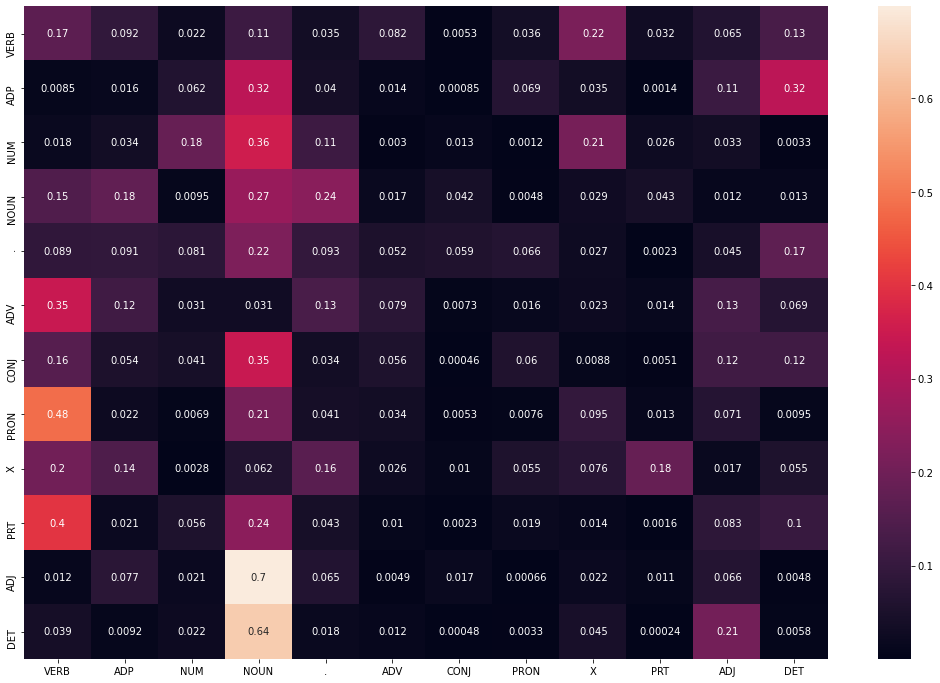

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot = True)
plt.show()

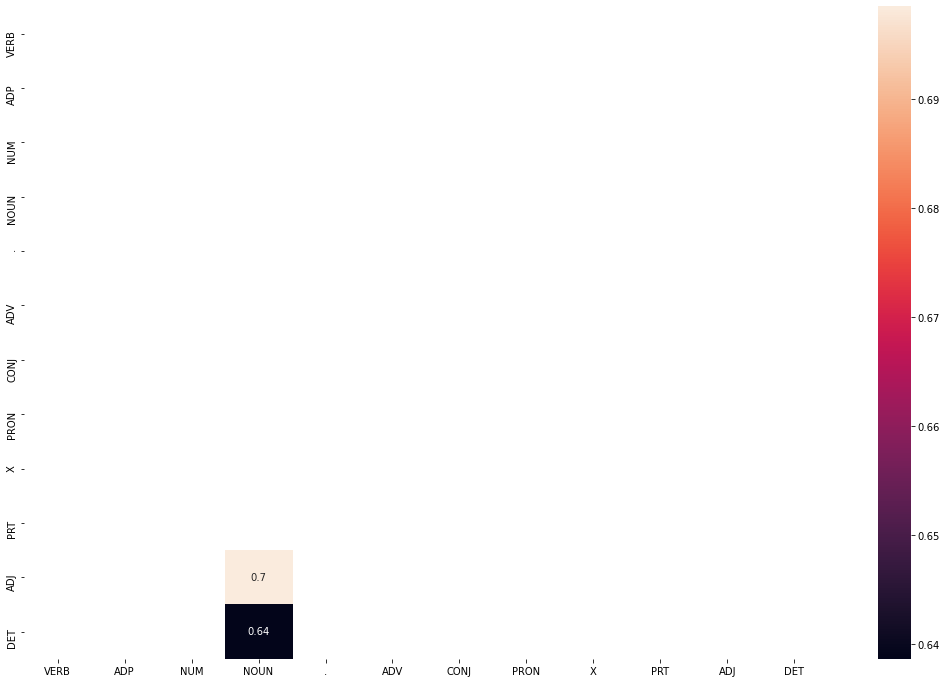

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot = True)
plt.show()

In [20]:
len(train_tagged_words)

95952

In [21]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating on Validation Set

In [22]:
# Let's test our Viterbi algorithm on validation dataset

#random.seed(100)

# list of tagged words
valdn_run_base = [tup for sent in valdn_set for tup in sent]

# list of untagged words
valdn_tagged_words = [tup[0] for sent in valdn_set for tup in sent]

valdn_tagged_words

['The',
 'U.S.',
 'government',
 'in',
 'recent',
 'years',
 'has',
 'accused',
 'Japanese',
 'companies',
 'of',
 '*',
 'excessively',
 'slashing',
 'prices',
 'on',
 'semiconductors',
 'and',
 'supercomputers',
 '--',
 'products',
 '0',
 'Fujitsu',
 'and',
 'NEC',
 'make',
 '*T*-1',
 '.',
 'Among',
 'segments',
 'that',
 '*T*-1',
 'continue',
 '*-2',
 'to',
 'operate',
 ',',
 'though',
 ',',
 'the',
 'company',
 "'s",
 'steel',
 'division',
 'continued',
 '*-3',
 'to',
 'suffer',
 'from',
 'soft',
 'demand',
 'for',
 'its',
 'tubular',
 'goods',
 'serving',
 'the',
 'oil',
 'industry',
 'and',
 'other',
 'markets',
 '.',
 'The',
 'Herald',
 'joins',
 'the',
 'Baltimore',
 'News-American',
 ',',
 'which',
 '*T*-46',
 'folded',
 ',',
 'and',
 'the',
 'Boston',
 'Herald-American',
 ',',
 'which',
 '*T*-1',
 'was',
 'sold',
 '*-62',
 ',',
 'as',
 'cornerstones',
 'of',
 'the',
 'old',
 'Hearst',
 'newspaper',
 'empire',
 'abandoned',
 '*',
 'by',
 'the',
 'company',
 'in',
 'the',
 '1980

In [23]:
# tagging the validation set using this model
start = time.time()
tagged_seq = Viterbi(valdn_tagged_words)
end = time.time()
difference = end-start

In [24]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1557.6123814582825
[('The', 'DET'), ('U.S.', 'NOUN'), ('government', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('has', 'VERB'), ('accused', 'VERB'), ('Japanese', 'ADJ'), ('companies', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('excessively', 'VERB'), ('slashing', 'VERB'), ('prices', 'NOUN'), ('on', 'ADP'), ('semiconductors', 'VERB'), ('and', 'CONJ'), ('supercomputers', 'NOUN'), ('--', '.'), ('products', 'NOUN'), ('0', 'X'), ('Fujitsu', 'NOUN'), ('and', 'CONJ'), ('NEC', 'NOUN'), ('make', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('Among', 'ADP'), ('segments', 'NOUN'), ('that', 'ADP'), ('*T*-1', 'X'), ('continue', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('operate', 'VERB'), (',', '.'), ('though', 'ADP'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('steel', 'NOUN'), ('division', 'NOUN'), ('continued', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('suffer', 'VERB'), ('from', 'ADP'), ('soft', 'ADJ'), ('demand', 'NOUN'), ('for', 'ADP'), ('its', 'P

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, valdn_run_base) if i == j] 

In [26]:
accuracy = len(check)/len(tagged_seq)
accuracy

0.9178662150719729

In [27]:
#Checking list of incorrectly tagged words
incorrect_tagged_cases = [[valdn_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, valdn_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

388
[[('*', 'X'), (('excessively', 'VERB'), ('excessively', 'ADV'))], [('on', 'ADP'), (('semiconductors', 'VERB'), ('semiconductors', 'NOUN'))], [('segments', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))], [('Baltimore', 'NOUN'), (('News-American', 'VERB'), ('News-American', 'NOUN'))], [('Boston', 'NOUN'), (('Herald-American', 'VERB'), ('Herald-American', 'NOUN'))], [('as', 'ADP'), (('cornerstones', 'VERB'), ('cornerstones', 'NOUN'))], [('newspaper', 'NOUN'), (('empire', 'VERB'), ('empire', 'NOUN'))], [('the', 'DET'), (('1980s', 'NOUN'), ('1980s', 'NUM'))], [('The', 'DET'), (('Soviet', 'ADJ'), ('Soviet', 'NOUN'))], [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))], [('the', 'DET'), (('Soviet', 'ADJ'), ('Soviet', 'NOUN'))], [('congressional', 'ADJ'), (('Republicans', 'VERB'), ('Republicans', 'NOUN'))], [('to', 'PRT'), (('compromise', 'NOUN'), ('compromise', 'VERB'))], [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))], [('Chairma

### Solve the problem of unknown words

In [30]:
#Checking the unknown words based on the validation set
valdn_token = set([t for t in valdn_tagged_words])

unknown_words = list(valdn_token - V)
print(len(unknown_words))
print(unknown_words)

303
['ushered', 'VanSant', 'exists', 'Wickliffe', 'PHOTOGRAPH', 'life-of-contract', 'floral', '*-114', 'THAT', 'collections', 'third-largest', 'residence', 'automation', 'damaging', 'projector', 'attending', 'buoyed', 'rough', 'Dugdale', 'phase-out', 'Herald-American', 'display', '240-page', 'ROGERS', '*-86', 'slashing', 'rampage', '340,000', 'manipulators', 'discarded', 'high-level', 'adequately', 'screened', 'pitches', '2.62', 'sabotage', 'errors', 'reaped', 'avid', 'Aerospace', 'printing-press', 'stacked', 'infusion', 'multilevel', 'spreads', 'non-encapsulating', '148.9', '0.84', '721', 'Abrupt', 'Noriega', 'Doak', 'oversee', '*T*-162', 'self-esteem', 'enviable', 'Avrett', 'Appellate', 'water-authority', 'tapping', 'cornerstones', '*-95', 'Cheetham', '71,309', 'Petersburg', 'Occidental', '456.64', 'turf', 'audiocassettes', 'drop-off', 'shambles', 'pick-up', '0.95', '93.3', 'fuming', 'carriers', 'Either', '6.4', 'folded', 'malignant', 'stripped', 'Namibia', '24,000', 'headcount-contr

In [31]:
# Modification technique 1
def ViterbiUnknownWords(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modifying the original vanilla viterbi algorithm for unknown words
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [32]:
# tagging the validation set using this model
start = time.time()
unknown_tagged_seq = ViterbiUnknownWords(valdn_tagged_words)
end = time.time()
difference = end-start

In [33]:
print("Time taken in seconds: ", difference)
print(unknown_tagged_seq)

Time taken in seconds:  1592.8933956623077
[('The', 'DET'), ('U.S.', 'NOUN'), ('government', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('has', 'VERB'), ('accused', 'VERB'), ('Japanese', 'ADJ'), ('companies', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('excessively', 'VERB'), ('slashing', 'X'), ('prices', 'NOUN'), ('on', 'ADP'), ('semiconductors', 'DET'), ('and', 'CONJ'), ('supercomputers', 'NOUN'), ('--', '.'), ('products', 'NOUN'), ('0', 'X'), ('Fujitsu', 'NOUN'), ('and', 'CONJ'), ('NEC', 'NOUN'), ('make', 'VERB'), ('*T*-1', 'X'), ('.', '.'), ('Among', 'ADP'), ('segments', 'NOUN'), ('that', 'ADP'), ('*T*-1', 'X'), ('continue', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('operate', 'VERB'), (',', '.'), ('though', 'ADP'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('steel', 'NOUN'), ('division', 'NOUN'), ('continued', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('suffer', 'VERB'), ('from', 'ADP'), ('soft', 'ADJ'), ('demand', 'NOUN'), ('for', 'ADP'), ('its', 'PRON'

In [34]:
# accuracy
unknown_check = [i for i, j in zip(unknown_tagged_seq, valdn_run_base) if i == j] 

unknown_accuracy = len(unknown_check)/len(unknown_tagged_seq)
unknown_accuracy

0.9343776460626587

#### Unigram model

In [36]:
#Using Unigram model to tag and test our data
start = time.time()
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(valdn_set)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(unigram_tagger_accuracy)

Time taken in seconds:  0.6833858489990234
0.9026248941574937


#### Rule Based Model(Regex) with unigram

In [37]:
# setting patterns for using a rule based regex tagger 
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # alpha numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'),        # special character combination
    (r'.*ould$', 'X'),                # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'),              # adjective
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'),# any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')    # numbers 
    ]

In [38]:
# unigram tagger with rule-based tagger as backoff model
start = time.time()
rule_based_tagger = nltk.RegexpTagger(patterns)
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
rule_based_unigram_tagger_accuracy = rule_based_unigram_tagger.evaluate(valdn_set)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(rule_based_unigram_tagger_accuracy)

Time taken in seconds:  1.854069709777832
0.9316257408975445


#### Bigram Model with rule based unigram

In [40]:
#Using Bigram model with rule_based_unigram_tagger as backoff
start = time.time()
bigram_tagger = nltk.BigramTagger(train_set, backoff = rule_based_unigram_tagger)
bigram_tagger_accuracy = bigram_tagger.evaluate(valdn_set)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(bigram_tagger_accuracy)

Time taken in seconds:  1.1258187294006348
0.9358594411515665


#### Trigram Model with bigram rule based unigram

In [41]:
#Using Bigram model with bigram_tagger as backoff
start = time.time()
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger_accuracy = trigram_tagger.evaluate(valdn_set)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(trigram_tagger_accuracy)

Time taken in seconds:  1.3672471046447754
0.9350127011007621


In [42]:
#Since Trigram rule based model gives better accuracy, modifying viterbi to use this model
def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # alpha numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg. photographers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'),        # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'),   # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [43]:
# Modification technique 2
def ViterbiTrigramTagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagged for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [46]:
# Evaluating the tagging for the validation set
start = time.time()
viterbi_trigram_tagged_seq = ViterbiTrigramTagger(valdn_tagged_words)
viterbi_trigram_check = [i for i, j in zip(viterbi_trigram_tagged_seq, valdn_run_base) if i == j]
viterbi_trigram_accuracy = len(viterbi_trigram_check)/len(viterbi_trigram_tagged_seq)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(viterbi_trigram_accuracy)

Time taken in seconds:  2991.3392136096954
0.9519475021168501


#### Evaluating tagging accuracy

In [47]:
#Comparing accuracies over all the built models
accuracy_cmp = [['Plain Vanilla Viterbi', accuracy*100], 
                  ['Viterbi for Unknown Words ', unknown_accuracy*100], 
                  ['Unigram Tagger', unigram_tagger_accuracy*100],
                  ['Rule based unigram tagger', rule_based_unigram_tagger_accuracy*100],
                  ['Bigram rule based unigram tagger', bigram_tagger_accuracy*100],
                  ['Trigram rule based unigram bigram tagger', trigram_tagger_accuracy*100],
                  ['Viterbi Trigram Tagger', viterbi_trigram_accuracy*100]]

acccuracy_df = pd.DataFrame(accuracy_cmp, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Plain Vanilla Viterbi,91.786622
Viterbi for Unknown Words,93.437765
Unigram Tagger,90.262489
Rule based unigram tagger,93.162574
Bigram rule based unigram tagger,93.585944
Trigram rule based unigram bigram tagger,93.501270
Viterbi Trigram Tagger,95.194750


Comparing the accuracy of data tags over different models, it is clearly indicative that Viterbi Trigram Tagger should be considered for modifying the vanilla viterbi heuristics.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [48]:
# Reading our Actual test dataset 
with open('Test_sentences.txt') as f:
    sentence_test = f.readlines()

sentence_test

['Android is a mobile operating system developed by Google.\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\n',
 'Show me the cheapest round trips from Dallas to Atlanta\n',
 'I would like to see flights from Denver to Philadelphia.\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\n',
 'NASA invited social medi

In [49]:
#Removing unwanted blank lines
test_set = [sent.strip() for sent in sentence_test if sent.strip()!='']
test_set

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [51]:
#Tokening words from test_sentences
nltk.download('averaged_perceptron_tagger')
test_tokens = [word_tokenize(sent) for sent in test_set]
test_data = nltk.pos_tag_sents(test_tokens, tagset = 'universal')
test_data

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [52]:
# list of untagged words for the test data
test_tagged_words = [tup[0] for sent in test_data for tup in sent]

# list of tagged words
test_run_base = [tup for sent in test_data for tup in sent]

In [53]:
test_run_base

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

#### Testing all the models on the test data

In [54]:
#Plain Vanilla Viterbi
start = time.time()
test_tagged_seq = Viterbi(test_tagged_words)
test_check = [i for i, j in zip(test_tagged_seq, test_run_base) if i == j]
test_data_viterbi_accuracy = len(test_check)/len(test_tagged_seq)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(test_data_viterbi_accuracy)

Time taken in seconds:  65.45482325553894
0.7679558011049724


In [55]:
#Viterbi for unknown words
start = time.time()
test_unknown_tagged_seq = ViterbiUnknownWords(test_tagged_words)
test_check1 = [i for i, j in zip(test_unknown_tagged_seq, test_run_base) if i == j]
test_data_viterbi_unknown_accuracy = len(test_check1)/len(test_unknown_tagged_seq)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(test_data_viterbi_unknown_accuracy)

Time taken in seconds:  62.15827035903931
0.861878453038674


In [56]:
#Viterbi with Trigram model
start = time.time()
test_trigram_tagged_seq = ViterbiTrigramTagger(test_tagged_words)
test_check2 = [i for i, j in zip(test_trigram_tagged_seq, test_run_base) if i == j]
test_data_trigram_accuracy = len(test_check2)/len(test_trigram_tagged_seq)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(test_data_trigram_accuracy)

Time taken in seconds:  244.76365900039673
0.9281767955801105


In [57]:
#Comparing accuracy for test_sentences over different models
test_accuracy_cmp = [['Plain Vanilla Viterbi', test_data_viterbi_accuracy*100], 
                      ['Viterbi for Unknown Words', test_data_viterbi_unknown_accuracy*100], 
                      ['Viterbi Trigram Tagger', test_data_trigram_accuracy*100]]

test_accuracy_df = pd.DataFrame(test_accuracy_cmp, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

test_accuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

test_accuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Plain Vanilla Viterbi,76.795580
Viterbi for Unknown Words,86.187845
Viterbi Trigram Tagger,92.817680


Even on unknown test sentences, the Viterbi Trigram tagger worked well and showed better accuracy compared to the other models.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [59]:
# Suppose we take the first sentence from our test set to understand how it was tagged in vanilla Viterbi compared to our modified model
test_sent1 = 'Android is a mobile operating system developed by Google.'

words_test_sent1 = nltk.word_tokenize(test_sent1)

# pos tags with Viterbi model
tagged_seq1_viterbi = Viterbi(words_test_sent1)
print(tagged_seq1_viterbi)

print("\n***********************************************************************************\n")

# pos tags with ViterbiTrigramTagger model
tagged_seq1_viterbi_trigram = ViterbiTrigramTagger(words_test_sent1)
print(tagged_seq1_viterbi_trigram)

[('Android', 'VERB'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'VERB'), ('.', '.')]

***********************************************************************************

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [60]:
#Comparing the resulting tags from models
cols = ['viterbi_tags', 'viterbi_trigram_tags']

new_tags1 = pd.DataFrame(columns = cols)
new_tags1 = new_tags1.fillna(0)

new_tags1.viterbi_tags = [tup for tup in tagged_seq1_viterbi]
new_tags1.viterbi_trigram_tags = [tup for tup in tagged_seq1_viterbi_trigram]

new_tags1

,viterbi_tags,viterbi_trigram_tags
0,"(Android, VERB)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, VERB)","(Google, NOUN)"
9,"(., .)","(., .)"


For the above sentence we can see that 'Android' and 'Google' these words were not known to the vanilla viterbi model, so it tagged these as verbs. But the modified Trigram Viterbi model was able to correctly tag it as nouns, even though their tags were unknown.

In [61]:
# Suppose we take the second sentence from our test set to understand how it was tagged in vanilla Viterbi compared to our modified model
test_sent2 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

words_test_sent2 = nltk.word_tokenize(test_sent2)

# pos tags with Viterbi model
tagged_seq2_viterbi = Viterbi(words_test_sent2)
print(tagged_seq2_viterbi)

print("\n***********************************************************************************\n")

# pos tags with ViterbiTrigramTagger model
tagged_seq2_viterbi_trigram = ViterbiTrigramTagger(words_test_sent2)
print(tagged_seq2_viterbi_trigram)

[('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'VERB'), ('.', '.')]

***********************************************************************************

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [62]:
#Comparing the resulting tags from models
cols = ['viterbi_tags', 'viterbi_trigram_tags']

new_tags2 = pd.DataFrame(columns = cols)
new_tags2 = new_tags2.fillna(0)

new_tags2.viterbi_tags = [tup for tup in tagged_seq2_viterbi]
new_tags2.viterbi_trigram_tags = [tup for tup in tagged_seq2_viterbi_trigram]

new_tags2

,viterbi_tags,viterbi_trigram_tags
0,"(Android, VERB)","(Android, NOUN)"
1,"(has, VERB)","(has, VERB)"
2,"(been, VERB)","(been, VERB)"
3,"(the, DET)","(the, DET)"
4,"(best-selling, ADJ)","(best-selling, ADJ)"
5,"(OS, VERB)","(OS, NOUN)"
6,"(worldwide, VERB)","(worldwide, NOUN)"
7,"(on, ADP)","(on, ADP)"
8,"(smartphones, VERB)","(smartphones, VERB)"
9,"(since, ADP)","(since, ADP)"


Even in this sentence we can see that the words 'Android' and 'worldwide' were tagged as verbs but the Trigram viterbi correctly tagged them as nouns. Also here we can see that the years '2011' and '2013' are tagged as verbs by the plain vanilla model. These are correctly tagged under number in our modified model.

Similarly, we can find more such scenarios in our remaining test sentences, which clearly suggests why we should use a combination of models over a vanilla viterbi model. Even the accuracy percent clearly indicated the argument.